In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# !pip install praw
# !pip install bert-serving-server  # server
# !pip install bert-serving-client
# instruction - https://www.kaggle.com/nicapotato/universal-sentence-encoder-clustering-poc
# https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb

In [2]:
# import praw
import pandas as pd
import datetime as dt
import re
import multiprocessing
# from bert_serving.client import BertClient
from sklearn.cluster import KMeans
import tensorflow_hub as hub

import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Ambassador Analytics/reddit_covid.csv')
df.head()

,Unnamed: 0,title,score,id,subreddit,url,num_comments,body,created
0,0,"NEW Welcome, Approvals and Flairs",62,fprwv0,COVID19_support,https://www.reddit.com/r/COVID19_support/comme...,278,**New Users**\n\nPlease contact the moderators...,2020-03-27 10:13:04
1,1,WEEKLY GOOD NEWS STICKY: 5-11 July 2020,11,hlvg20,COVID19_support,https://www.reddit.com/r/COVID19_support/comme...,1,I hope everyone here had as good a weekend as ...,2020-07-06 02:17:41
2,2,Seeing my friends with long haul post-COVID sy...,119,hptkhv,COVID19_support,https://www.reddit.com/r/COVID19_support/comme...,16,"Hey all,\n\nI am a contact tracer working on t...",2020-07-12 16:23:05
3,3,My father just tested positive. He is 63 and h...,5,hpwzfm,COVID19_support,https://www.reddit.com/r/COVID19_support/comme...,2,"I know this is rediculous, I know that no one ...",2020-07-12 20:16:00
4,4,School Anxiety,13,hprqte,COVID19_support,https://www.reddit.com/r/COVID19_support/comme...,2,Schools open back for the fall semester about ...,2020-07-12 13:35:16


In [4]:
# bc = BertClient()
# title_list = df['title'].tolist()
# BERT_embedding = bc.encode(title_list)

module_url = 'https://tfhub.dev/google/universal-sentence-encoder-large/4'
USE_embed = hub.KerasLayer(module_url, trainable=False, name='USE_embedding')

In [5]:
train_embeddings = USE_embed(df.title)['outputs'].numpy()

In [6]:
SEED = 42

In [7]:
#Elbow method

# function returns WSS score for k values from 1 to kmax
def calculate_WSS(points, kmax):
  sse = []
  for k in range(1, kmax+1):
    kmeans = KMeans(n_clusters = k, random_state= SEED).fit(points)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(points)
    curr_sse = 0
    
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
    for i in range(len(points)):
      curr_center = centroids[pred_clusters[i]]
      curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
      
    sse.append(curr_sse)
  return sse

In [8]:
elbow_method = calculate_WSS(train_embeddings,30)

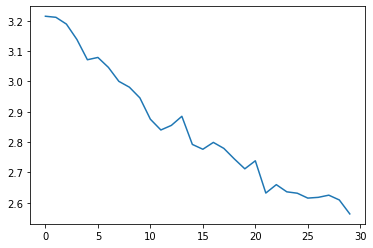

In [9]:
plt.plot(elbow_method)

In [11]:
from sklearn.metrics import silhouette_score

sil = []
kmax = 30

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k, random_state= SEED).fit(train_embeddings)
  labels = kmeans.labels_
  sil.append(silhouette_score(train_embeddings, labels, metric = 'euclidean'))

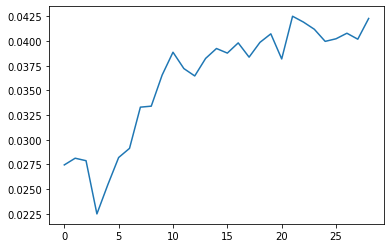

In [12]:
plt.plot(sil)

In [14]:
kmeans = KMeans(n_clusters=20, random_state= SEED).fit(train_embeddings)

In [15]:
df.loc[:,'Clusters'] = None
df.loc[:,'Clusters'] = kmeans.labels_

In [16]:
temp = df[['title','Clusters']]
temp

,title,Clusters
0,"NEW Welcome, Approvals and Flairs",4
1,WEEKLY GOOD NEWS STICKY: 5-11 July 2020,16
2,Seeing my friends with long haul post-COVID sy...,5
3,My father just tested positive. He is 63 and h...,12
4,School Anxiety,6
...,...,...
985,the little routines that i miss the most,0
986,I finally just laid in bed and cried all day,5
987,A Letter From My Doctor #2: My physician has b...,5
988,Can anyone give me tips on how to cope with th...,19


In [17]:
for i in range(20):
  print(temp[temp['Clusters'] == i].head(10))
  print('\n\n')

                                                 title  Clusters
9                      Is there any hope for the U.S.?         0
25   COVID-19 has begun to rob me of my hope for th...         0
68                      Is This Really The New Normal?         0
89                Can't find any reasons to be hopeful         0
94   Will I ever get my sense of smell and taste ba...         0
134  Overwhelmed now that normal life is slowly com...         0
222          Still don't have much hope for the future         0
327               First time out in the new “ normal “         0
338      Two realities. Not sure what is real anymore.         0
404  I'm starting to think there's nothing to look ...         0



                                                 title  Clusters
8                              Covid-19 and loneliness         1
24     Feeling like my future was thrown into disarray         1
42                 Feeling more helpless with each day         1
46                    

In [ ]:
#LDA title

**LDA TITLE**

---



In [22]:
# !pip install pyLDAvis

In [36]:
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [37]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df.title.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['new', 'welcome', 'approvals', 'and', 'flairs']]


In [54]:

bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    # texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [[word for word in simple_preprocess(str(doc))] for doc in texts] #not using stop words
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    # texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]  
    texts_out = [[word for word in simple_preprocess(str(doc))] for doc in texts_out]    
  
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [57]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.240*"just" + 0.108*"test" + 0.051*"here" + 0.044*"week" + 0.035*"need" + '
  '0.032*"positive" + 0.028*"info" + 0.025*"vent" + 0.025*"bed" + '
  '0.017*"hurt"'),
 (1,
  '0.064*"pandemic" + 0.062*"infect" + 0.049*"say" + 0.044*"business" + '
  '0.038*"live" + 0.038*"anxious" + 0.036*"situation" + 0.034*"place" + '
  '0.030*"possibly" + 0.028*"there"'),
 (2,
  '0.093*"will" + 0.076*"care" + 0.059*"risk" + 0.055*"sick" + 0.042*"office" '
  '+ 0.039*"catch" + 0.039*"worry" + 0.031*"way" + 0.027*"baby" + '
  '0.025*"lately"'),
 (3,
  '0.143*"covid" + 0.070*"have" + 0.055*"symptom" + 0.039*"miss" + '
  '0.034*"share" + 0.034*"see" + 0.029*"long" + 0.028*"report" + '
  '0.026*"friend" + 0.024*"one"'),
 (4,
  '0.065*"little" + 0.064*"freak" + 0.053*"could" + 0.048*"would" + '
  '0.039*"disappear" + 0.039*"short" + 0.035*"start" + 0.033*"lonely" + '
  '0.031*"tell" + 0.028*"overwhelmed"'),
 (5,
  '0.073*"letter" + 0.066*"too" + 0.056*"over" + 0.045*"community" + '
  '0.042*"send" + 0.

In [58]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,17.0,0.8100,"anxiety, minute, class, finally, routine, open...","[new, welcome, approval, flair]"
1,1,0.0,0.0500,"just, test, here, week, need, positive, info, ...",[]
2,2,3.0,0.6419,"covid, have, symptom, miss, share, see, long, ...","[see, friend, long, haul, covid, symptom, dest..."
3,3,0.0,0.7050,"just, test, here, week, need, positive, info, ...","[father, just, test, positive, heart, issue, j..."
4,4,17.0,0.6833,"anxiety, minute, class, finally, routine, open...","[school, anxiety]"
5,5,9.0,0.8377,"go, work, back, people, quarantine, break, wor...","[esthetician, mother, disease, thyroid, former..."
6,6,10.0,0.6833,"feel, can, anymore, point, scared, check, depr...","[feel, can]"
7,7,3.0,0.4317,"covid, have, symptom, miss, share, see, long, ...","[have, workplace, issue, exactly, contact]"
8,8,3.0,0.3500,"covid, have, symptom, miss, share, see, long, ...","[covid, loneliness]"
9,9,1.0,0.5250,"pandemic, infect, say, business, live, anxious...",[hope]


In [59]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.8417,"just, test, here, week, need, positive, info, vent, bed, hurt","[in, here, recent, positive, test]"
1,1.0,0.8100,"pandemic, infect, say, business, live, anxious, situation, place, possibly, there","[statement, safety, reusable, item]"
2,2.0,0.8100,"will, care, risk, sick, office, catch, worry, way, baby, lately","[summer, fomo, kind, of]"
3,3.0,0.8100,"covid, have, symptom, miss, share, see, long, report, friend, one","[share, video, word, comfort]"
4,4.0,0.8643,"little, freak, could, would, disappear, short, start, lonely, tell, overwhelmed","[start, freak, little, could, use, reassurance]"
5,5.0,0.6833,"letter, too, over, community, send, infection, practice, low, bathroom, as","[shit, over]"
6,6.0,0.8417,"be, so, give, parent, afraid, rant, again, crazy, alone, act","[be, afraid, give, birth, alone]"
7,7.0,0.8417,"how, make, write, ever, sure, most, close, lung, end, manage","[sweet, taste, smell, spray, deodorant]"
8,8.0,0.7625,"stress, advice, lockdown, wash, husband, wedding, second, wave, all, evidence","[question, public, transportation]"
9,9.0,0.8377,"go, work, back, people, quarantine, break, worried, tip, fall, state","[esthetician, mother, disease, thyroid, former, heart, attack, go, back, work, rub, lotion, peop..."


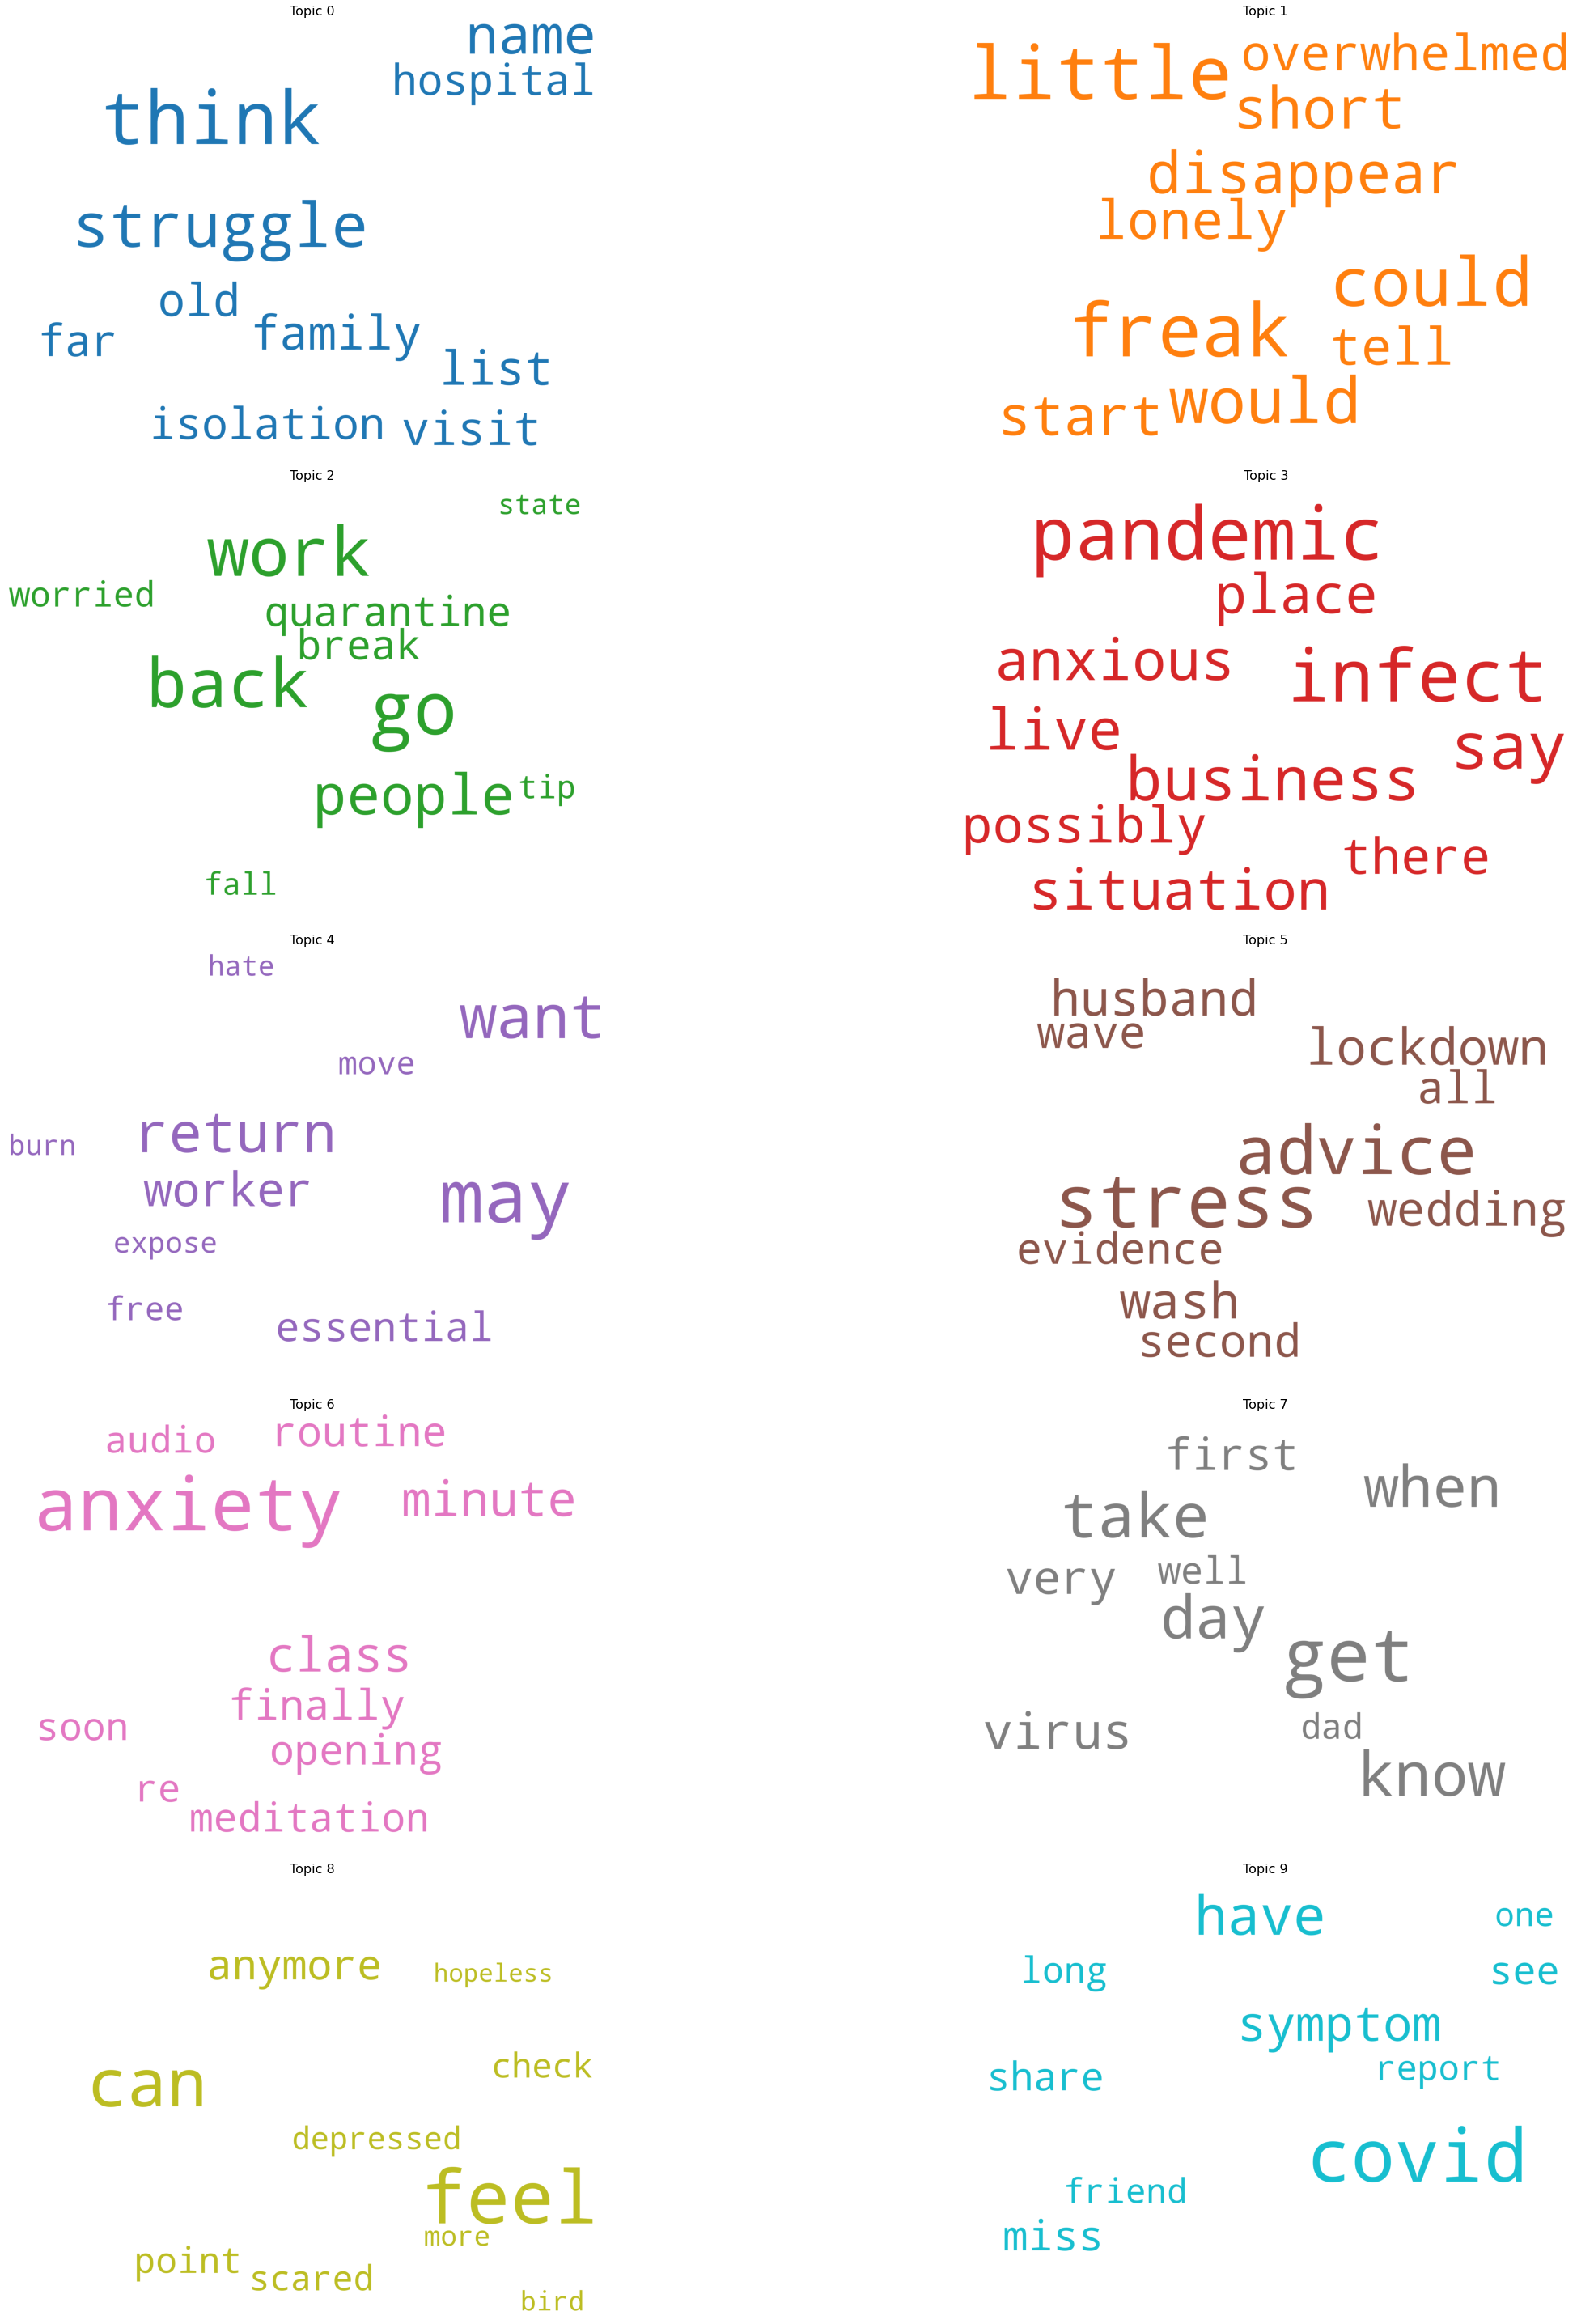

In [72]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(#stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=50,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 2, figsize=(40,40), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()